In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skopt import gp_minimize
from astropy.coordinates import SkyCoord
from astropy import units as u

Загружаем таблицы, скачанные с [каталога](http://vizier.cfa.harvard.edu/viz-bin/VizieR?-source=J/A+A/596/A14)

In [8]:
gr_s = pd.read_csv('./grlist_s.csv') #List of groups and their parameters detected in SDSS DR12
gr_2 = pd.read_csv('./grlist_2.csv') #List of groups and their parameters detected in 2MRS
ga_s = pd.read_csv('./galist_s.csv') #List of SDSS galaxies used, as well as their IDs and coordinates
ga_2 = pd.read_csv('./galist_2.csv') #List of 2MRS galaxies used, as well as their IDs and coordinates

Сортируем по iGrID

In [9]:
gr_s= gr_s.sort_values(by = 'iGrID')
gr_2= gr_2.sort_values(by = 'iGrID')
ga_s= ga_s.sort_values(by = 'iGrID')
ga_2= ga_2.sort_values(by = 'iGrID')

Оставляем группы, у которых количество галактик больше 30

In [10]:
gr_s = gr_s[gr_s.Ntot>30]
ga_s = ga_s.loc[ga_s['iGrID'].isin(gr_s.iGrID)]
gr_2 = gr_2[gr_2.Ntot>30]
ga_2 = ga_2.loc[ga_2['iGrID'].isin(gr_2.iGrID)]

Объединяем таблицы групп и галактик для 2MRS и SDSS. К таблицам с галактиками добавляем колонки из таблиц для групп галактик. 

In [12]:
g_list_2 = pd.merge(ga_2, gr_2, on='iGrID', how='left',suffixes=('_gal','_group')) # 2MRS
g_list_s = pd.merge(ga_s, gr_s, on='iGrID', how='left',suffixes=('_gal','_group')) # SDSS
g_list_s = g_list_s.drop(['Dist_gal','Dist_group'], axis=1)

In [14]:
#g_list_2.to_csv(path_or_buf='glist_2.csv', index=False)
#g_list_s.to_csv(path_or_buf='glist_s.csv', index=False)

Напишем функцию для построения scatter plot для групп галактик по 
 OX: угловое расстояние от галактики до центра группы,
 OY: разница между красным смещением галактики и красным смещением центра

In [18]:
def retrieve_name(x, Vars=vars()):
    for k in Vars:
        if type(x) == type(Vars[k]):
            if x is Vars[k]:
                return k
    return None

def plot_z_sep(number_iGrID, g_list):
    # берем группу из g_list с iGrID=number_iGrID
    example = g_list[g_list.iGrID==number_iGrID]
    # находим угловое расстояние между каждой галактикой в группе до центра группы
    ra_gal = list(example.RAJ2000_gal)
    dec_gal = list(example.DEJ2000_gal)
    ra_gr = list(example.RAJ2000_group)
    dec_gr = list(example.DEJ2000_group)
    c1 = SkyCoord(ra_gal,dec_gal, unit='deg',frame='icrs')
    c2 = SkyCoord(ra_gr, dec_gr, unit='deg', frame='icrs')
    sep = c1.separation(c2)
    sep = sep.deg
    # находим разницу между красным смещением галактик и красным смещением центра
    z_gal = np.array(example.z_gal)
    z_gr = np.array(example.z_group)
    z_dif = z_gal - z_gr
    # рисуем график
    fig, ax = plt.subplots()
    plt.scatter(sep, z_dif, s=15.15, color='black', marker='o')
    plt.xlabel('distance from center in degrees')
    plt.ylabel('z_gal - z_group')
    y_lim = np.max(abs(z_dif))*1.3
    plt.ylim([-y_lim, y_lim])
    plt.title(retrieve_name(g_list)+', iGrID = '+str(number_iGrID))
    plt.tight_layout()
    #plt.savefig(retrieve_name(g_list)+', iGrID = '+str(number_iGrID)+'.png', dpi=1000)
    plt.show()

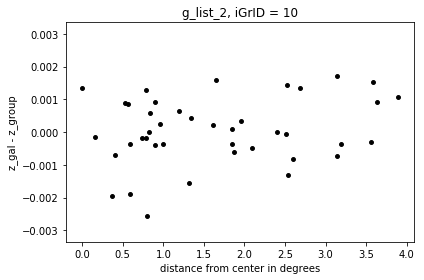

In [19]:
plot_z_sep(10, g_list_2)